In [38]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import kerastuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


In [39]:
# check if GPU is available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


# Define the needed infromations

In [40]:
batch_size = 2048 # i use 2048 because i have 12GB VRAM 👀
img_size = (100, 100) 
epochs = 2 # use low epochs for to save time only 
train_dir = 'oututv2/train'
test_dir = 'oututv2/test'

# Define the Generators and load the data

In [41]:
train_datagen = ImageDataGenerator(rescale=1./255) # rescale -> normalize
test_datagen = ImageDataGenerator(rescale=1./255) # rescale -> normalize

In [42]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical', # because we use categorical_crossentropy loss
   )
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    )

Found 72000 images belonging to 9 classes.
Found 18000 images belonging to 9 classes.


# Define Functions to use them while training and testing

In [45]:
def build_model(hp):
    """ Build model with hyperparameters

    Args:
        hp : hyperparameter tuning object

    Returns:
        model : model with hyperparameters
    """
    model = Sequential()
    model.add(Flatten(input_shape=img_size + (3,)))

    # Tune the number of layers
    for i in range(hp.Int('num_layers', 2, 6)):
        # Tune the number of neurons for each layer
        model.add(
            Dense(
                units=hp.Int(
                    f'units_{str(i)}', min_value=32, max_value=512, step=32
                ),
                activation=hp.Choice(
                    f'act_{str(i)}', ['relu', 'tanh', 'sigmoid']
                ),
            )
        )

    model.add(Dense(train_generator.num_classes, activation='softmax'))

    # Tune the learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]) # this 3 common learning rate to simulate large step and medium step and small step

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [46]:
def tune_hyperparameters(train_generator, test_generator, epochs, batch_size, num_trials):
    """ Tune hyperparameters with kerastuner and return best hyperparameters 

    Args:
        train_generator:  train data generator
        test_generator :  test data generator
        epochs (int) :   number of epochs
        batch_size (int): the batch size to use
        num_trials (int):  number of trials to run the search for the best hyperparameters

    Returns:
        best_hps : best hyperparameters
    """
    # Create a tuner with the required hyperparameters
    
    tuner = kt.RandomSearch(build_model,
                             objective='val_accuracy',
                             max_trials=num_trials,
                             directory='my_dir',
                             project_name='my_project')

    # Perform the search for the best hyperparameters
    tuner.search(train_generator,
                 epochs=epochs,
                 batch_size=batch_size,
                 validation_data=test_generator)

    return tuner.get_best_hyperparameters(num_trials=1)[0]

In [47]:
def build_best_model(best_hps):
    """ Build model with best hyperparameters

    Args:
        best_hps :  best hyperparameters

    Returns:
         model with best hyperparameters
    """
    model = Sequential()
    model.add(Flatten(input_shape=img_size + (3,)))

    for i in range(best_hps.get('num_layers')):
        model.add(
            Dense(
                units=best_hps.get(f'units_{str(i)}'),
                activation=best_hps.get(f'act_{str(i)}'),
            )
        )

    model.add(Dense(train_generator.num_classes, activation='softmax'))

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=best_hps.get('learning_rate')),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Training 

In [49]:
# Tune the hyperparameters
best_hps = tune_hyperparameters(train_generator, test_generator, epochs, batch_size, 2)


Trial 2 Complete [00h 01m 25s]
val_accuracy: 0.1111111119389534

Best val_accuracy So Far: 0.11511111259460449
Total elapsed time: 00h 02m 50s
INFO:tensorflow:Oracle triggered exit


In [52]:
best_model = build_best_model(best_hps)

# Try different Approaches to prevent overfitting
#### 1. Dropout
#### 2. Early Stopping
#### 3. Dropout
##### I done them after finding the best model to be able to compare them and see the best way in this case

# Approach 1: Regularization

In [53]:
reg_model = build_best_model(best_hps)
reg_model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
reg_model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
reg_model.add(Dense(train_generator.num_classes, activation='softmax'))

reg_model.compile(optimizer=keras.optimizers.Adam(learning_rate=best_hps.get('learning_rate')),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Approach 2: Early Stopping


In [54]:
earlystop_model = build_best_model(best_hps)
earlystop_model.add(Dense(64, activation='relu'))
earlystop_model.add(Dense(64, activation='relu'))
earlystop_model.add(Dense(train_generator.num_classes, activation='softmax'))

earlystop_model.compile(optimizer=keras.optimizers.Adam(learning_rate=best_hps.get('learning_rate')),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=2)

# Approach 3: Dropout

In [55]:
# Approach 3: Dropout
dropout_model = build_best_model(best_hps)
dropout_model.add(Dense(64, activation='relu'))
dropout_model.add(tf.keras.layers.Dropout(0.2))
dropout_model.add(Dense(64, activation='relu'))
dropout_model.add(tf.keras.layers.Dropout(0.2))
dropout_model.add(Dense(train_generator.num_classes, activation='softmax'))

dropout_model.compile(optimizer=keras.optimizers.Adam(learning_rate=best_hps.get('learning_rate')),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])


In [56]:
history_best = best_model.fit(train_generator,
                              epochs=3,
                              batch_size=batch_size,
                              validation_data=test_generator,
                              )

Epoch 1/3
36/36 [==============================] - 42s 1s/step - loss: 2.2308 - accuracy: 0.1103 - val_loss: 2.1974 - val_accuracy: 0.1126
Epoch 2/3
36/36 [==============================] - 40s 1s/step - loss: 2.1977 - accuracy: 0.1115 - val_loss: 2.1973 - val_accuracy: 0.1151
Epoch 3/3
36/36 [==============================] - 40s 1s/step - loss: 2.1974 - accuracy: 0.1121 - val_loss: 2.1972 - val_accuracy: 0.1185


In [57]:
history_reg = reg_model.fit(train_generator,
                            epochs=3,
                            validation_data=test_generator,
                            batch_size=batch_size,)

Epoch 1/3
36/36 [==============================] - 41s 1s/step - loss: 2.2762 - accuracy: 0.1140 - val_loss: 2.2741 - val_accuracy: 0.1149
Epoch 2/3
36/36 [==============================] - 39s 1s/step - loss: 2.2722 - accuracy: 0.1138 - val_loss: 2.2702 - val_accuracy: 0.1171
Epoch 3/3
36/36 [==============================] - 39s 1s/step - loss: 2.2682 - accuracy: 0.1235 - val_loss: 2.2663 - val_accuracy: 0.1291


In [58]:
history_earlystop = earlystop_model.fit(train_generator,
                                        epochs=3,
                                        batch_size = batch_size,
                                        validation_data=test_generator,
                                        callbacks=[early_stopping])

Epoch 1/3
36/36 [==============================] - 41s 1s/step - loss: 2.1973 - accuracy: 0.1098 - val_loss: 2.1971 - val_accuracy: 0.1131
Epoch 2/3
36/36 [==============================] - 40s 1s/step - loss: 2.1969 - accuracy: 0.1139 - val_loss: 2.1967 - val_accuracy: 0.1195
Epoch 3/3
36/36 [==============================] - 40s 1s/step - loss: 2.1962 - accuracy: 0.1212 - val_loss: 2.1958 - val_accuracy: 0.1226


In [61]:
history_dropout = dropout_model.fit(train_generator,
                                    epochs=3,
                                    batch_size = batch_size,
                                    validation_data=test_generator,
                                    )

Epoch 1/3
36/36 [==============================] - 40s 1s/step - loss: 2.1970 - accuracy: 0.1136 - val_loss: 2.1965 - val_accuracy: 0.1148
Epoch 2/3
36/36 [==============================] - 38s 1s/step - loss: 2.1965 - accuracy: 0.1158 - val_loss: 2.1960 - val_accuracy: 0.1213
Epoch 3/3
36/36 [==============================] - 40s 1s/step - loss: 2.1958 - accuracy: 0.1195 - val_loss: 2.1948 - val_accuracy: 0.1349


## Plot the comparison between the best model and the best model with the techniques to prevent overfitting on the 

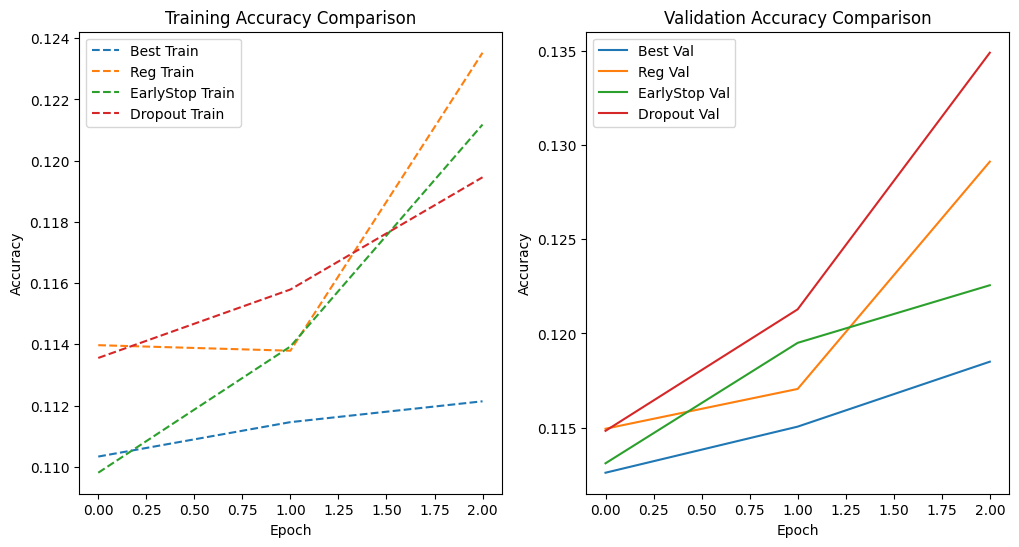

In [63]:
import matplotlib.pyplot as plt

# Plot the accuracy comparison for the different models
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot training accuracy
ax1.plot(history_best.history['accuracy'], label='Best Train', linestyle='dashed')
ax1.plot(history_reg.history['accuracy'], label='Reg Train', linestyle='dashed')
ax1.plot(history_earlystop.history['accuracy'], label='EarlyStop Train', linestyle='dashed')
ax1.plot(history_dropout.history['accuracy'], label='Dropout Train', linestyle='dashed')

# Plot validation accuracy
ax2.plot(history_best.history['val_accuracy'], label='Best Val')
ax2.plot(history_reg.history['val_accuracy'], label='Reg Val')
ax2.plot(history_earlystop.history['val_accuracy'], label='EarlyStop Val')
ax2.plot(history_dropout.history['val_accuracy'], label='Dropout Val')

# Set titles and labels
ax1.set_title('Training Accuracy Comparison')
ax2.set_title('Validation Accuracy Comparison')
ax1.set_xlabel('Epoch')
ax2.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax2.set_ylabel('Accuracy')
ax1.legend()
ax2.legend()

plt.show()


## See the effect of batch size on the Accuracy of the model

In [67]:
batch_sizes = [16, 32, 64, 128, 256, 512, 1024,2048] # make it dynamic 


In [68]:
train_accuracies = []
test_accuracies = []

for batch_size in batch_sizes:
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    model = build_best_model(best_hps)

    history = model.fit(
        train_generator,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=test_generator,
    )
    
    train_accuracies.append(history.history['accuracy'][-1])
    test_accuracies.append(history.history['val_accuracy'][-1])



Found 72000 images belonging to 9 classes.
Found 18000 images belonging to 9 classes.
Epoch 1/2
4500/4500 [==============================] - 68s 15ms/step - loss: 2.2047 - accuracy: 0.1109 - val_loss: 2.2008 - val_accuracy: 0.1111
Epoch 2/2
4500/4500 [==============================] - 52s 12ms/step - loss: 2.2027 - accuracy: 0.1117 - val_loss: 2.2005 - val_accuracy: 0.1111
Found 72000 images belonging to 9 classes.
Found 18000 images belonging to 9 classes.
Epoch 1/2
2250/2250 [==============================] - 50s 22ms/step - loss: 2.2019 - accuracy: 0.1141 - val_loss: 2.2006 - val_accuracy: 0.1159
Epoch 2/2
2250/2250 [==============================] - 47s 21ms/step - loss: 2.2004 - accuracy: 0.1149 - val_loss: 2.1978 - val_accuracy: 0.1153
Found 72000 images belonging to 9 classes.
Found 18000 images belonging to 9 classes.
Epoch 1/2
1125/1125 [==============================] - 44s 38ms/step - loss: 2.2011 - accuracy: 0.1116 - val_loss: 2.2004 - val_accuracy: 0.1116
Epoch 2/2
1125/11

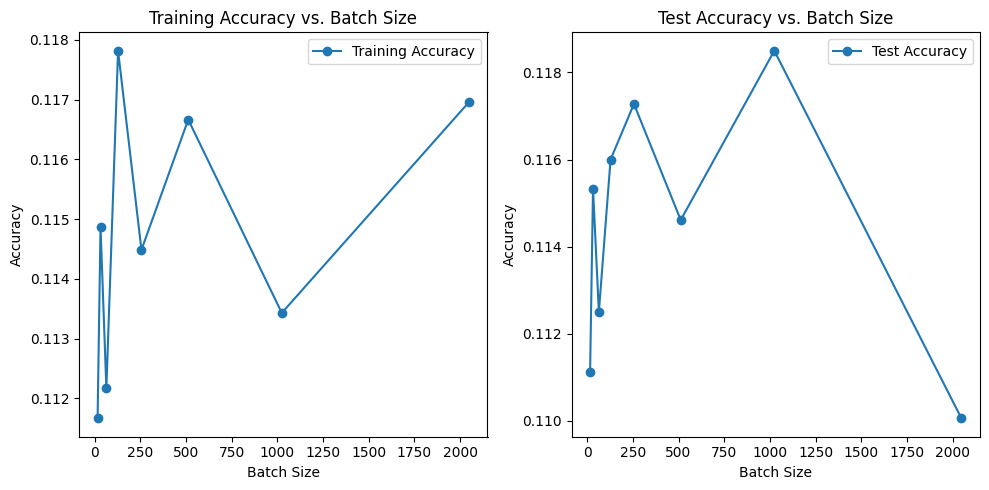

In [69]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(batch_sizes, train_accuracies, 'o-', label='Training Accuracy')
plt.xlabel('Batch Size')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs. Batch Size')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(batch_sizes, test_accuracies, 'o-', label='Test Accuracy')
plt.xlabel('Batch Size')
plt.ylabel('Accuracy')
plt.title('Test Accuracy vs. Batch Size')
plt.legend()

plt.tight_layout()
plt.show()
